<h1><center>Using Predictive Modeling and Machine Learning
to Advise P2P Investing Decisions</center></h1>

Lending Club is a peer-to-peer lending service which allows investors to lend money to borrowers. An investor's return will vary, with a lot of variance coming from the default rate of the loans they invest in. As a result, an investor's ability to predict the likelihood of default of various borrowers will have a significant effect on their bottom line.

Lending Club provides historical data for loans made through the company in the past, through 2007. We use historical data to build models predicting likelihood of a loan being paid back, then test these models on data on the 6 months that follow. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

loan = pd.read_csv('accepted_2007_to_2018Q4.csv')

### Data Cleaning

The first order of business is converting dates in a string format to a datetime format, and also changing dates for factors such as earliest credit line to more useful formats (in this case, days since earliest credit line at time of loan application).

In [2]:
# Dictionary that returns corresponding month number when given a 3-letter string
return_number = {
    'Jan': 1,
    'Feb': 2,
    'Mar': 3,
    'Apr': 4,
    'May': 5,
    'Jun': 6,
    'Jul': 7,
    'Aug': 8,
    'Sep': 9,
    'Oct': 10,
    'Nov': 11,
    'Dec': 12
}

# Function that converts string date format to datetime format
def convert_date(d):
    try:
        return datetime.date(year=int(d[4:]), month=return_number[d[:3]], day=1)
    except:
        pass

# Apply function to issue_d and earliest_cr_line fields
loan['issue_d'] = loan['issue_d'].apply(convert_date)
loan['earliest_cr_line'] = loan['earliest_cr_line'].apply(convert_date)

# Restrict analysis to loans originating from January 2010 to July 2015
loan = loan[loan.issue_d < datetime.date(2015,7,1)]
loan = loan[loan.issue_d >= datetime.date(2010,1,1)]
loan = loan[loan.term == ' 36 months']

# Modify earliest_cr_line field to reflect days since opening, relative to loan application
loan['earliest_cr_line'] = loan.apply(lambda x: (x['issue_d'] - x['earliest_cr_line']).days, axis=1)

In [3]:
# Loans by current status
loan.loan_status.value_counts()

Fully Paid                                             388613
Charged Off                                             61206
Does not meet the credit policy. Status:Fully Paid        532
Does not meet the credit policy. Status:Charged Off       158
Current                                                     1
Name: loan_status, dtype: int64

It appears that approximately 1/8 of loans that meet Lending Club's credit policy are paid back. We restrict our analysis to loans that meet this policy.

In [4]:
# Restrict analysis to loans that met the credit policy
loan = loan[(loan.loan_status == 'Fully Paid') | (loan.loan_status == 'Charged Off')]

### Exploratory Analysis

I'm using 15 variables that have been shown in prior analysis to have an impact on likelihood of repayment


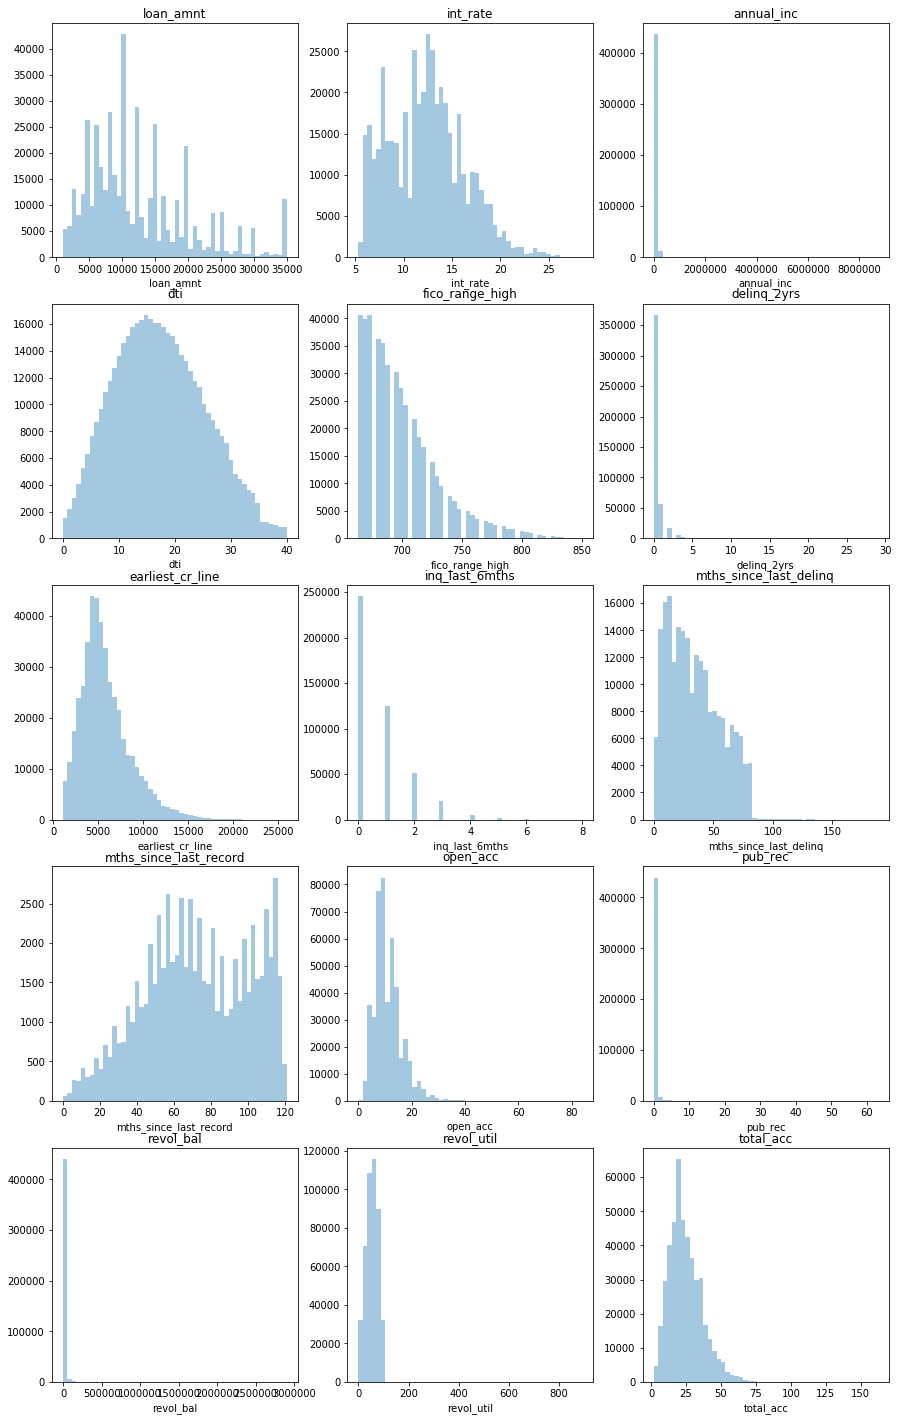

In [5]:
# I'm using 15 variables that have been shown in prior analysis to have an impact on likelihood of repayment
col_list = ['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'fico_range_high', 'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc']

plt.figure(figsize=(15,25))

for i in range(len(col_list)):
    plt.subplot(5,3,i+1)
    plt.title(col_list[i])
    sns.distplot(loan[col_list[i]].dropna(), kde=False)
    
plt.show()

Some of these factors very obviously are distributed non-normally. Some, such as annual income, should behave better as log variables, while others, such as credit score, will be tough to coerce to a normal-like distribution. For many variables, I did attempt other types of transformations, such as Box-Cox or square root transformations, but they didn't show any benefit over log transformation. Additionally, using log or square root transofrmations will take out a level of complexity when forecasting live data, as prior transformations won't need to be saved for future use.

In [6]:
loan.acc_now_delinq.value_counts()

0.0     447945
1.0       1753
2.0         97
3.0         17
4.0          4
14.0         1
6.0          1
5.0          1
Name: acc_now_delinq, dtype: int64

In [7]:
loan[loan.annual_inc > 1000000].shape

(62, 151)

In [8]:
loan = loan[loan.annual_inc < 1000000]
loan.shape

(449742, 151)

I decide that incomes above $1,000,000 are potentially errors, and if they aren't, are extreme outliers. I omit them from the analysis

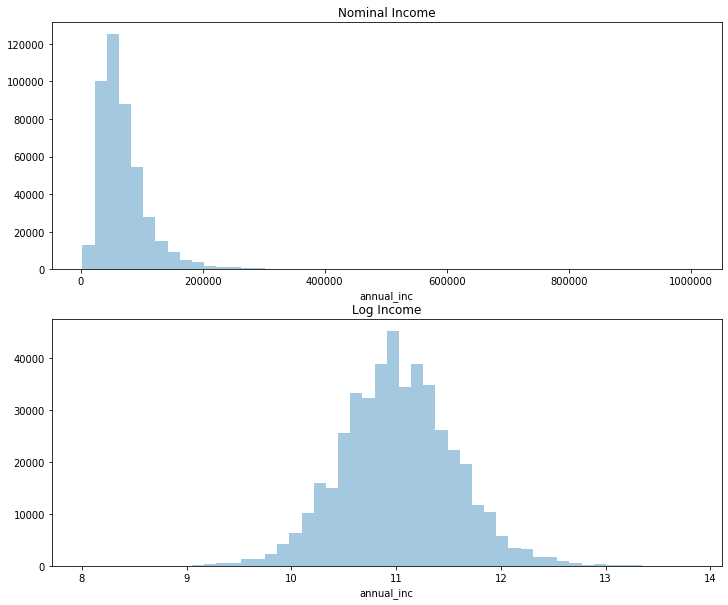

In [9]:
plt.figure(figsize=(12,10))

plt.subplot(2,1,1)
plt.title('Nominal Income')
sns.distplot(loan.annual_inc, kde=False)

plt.subplot(2,1,2)
plt.title('Log Income')
sns.distplot(np.log(loan.annual_inc), kde=False)

plt.show()

In [10]:
loan['ln_annual_inc'] = np.log(loan.annual_inc)

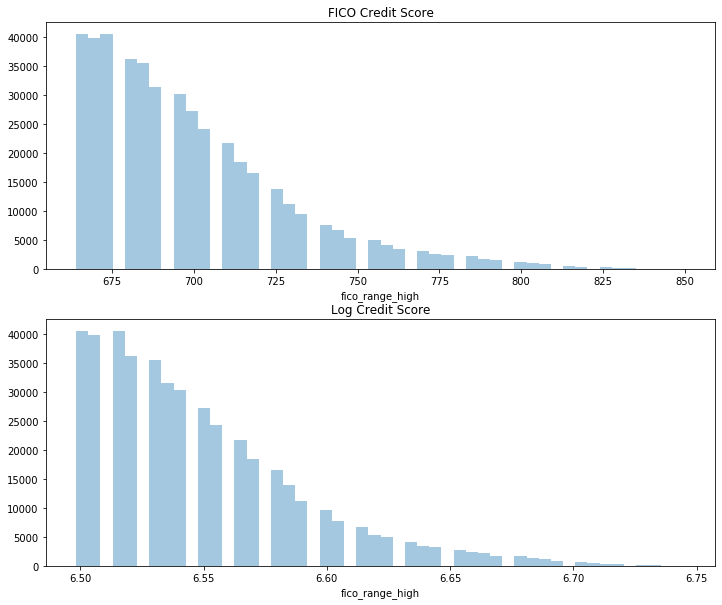

In [11]:
plt.figure(figsize=(12,10))

plt.subplot(2,1,1)
plt.title('FICO Credit Score')
sns.distplot(loan.fico_range_high, kde=False)

plt.subplot(2,1,2)
plt.title('Log Credit Score')
sns.distplot(np.log(loan.fico_range_high), kde=False)

plt.show()

My intuition is that Lending Club requires a certain credit score to apply for loans. There is no reasonable transform that will make this factor normally distributed.

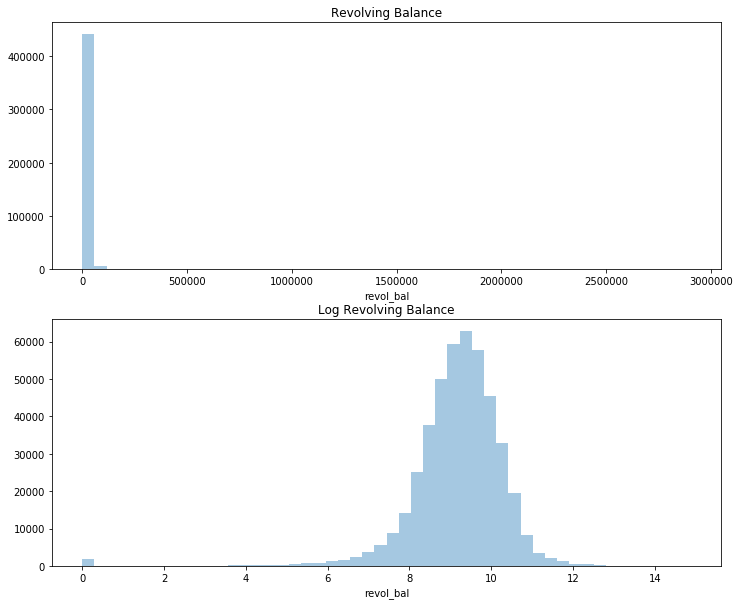

In [12]:
plt.figure(figsize=(12,10))

plt.subplot(2,1,1)
plt.title('Revolving Balance')
sns.distplot(loan.revol_bal, kde=False)

plt.subplot(2,1,2)
plt.title('Log Revolving Balance')
sns.distplot(np.log(loan.revol_bal+1), kde=False)

plt.show()

In [13]:
loan = loan[loan.revol_util < 150]
loan['ln_revol_bal'] = np.log(loan.revol_bal+1)

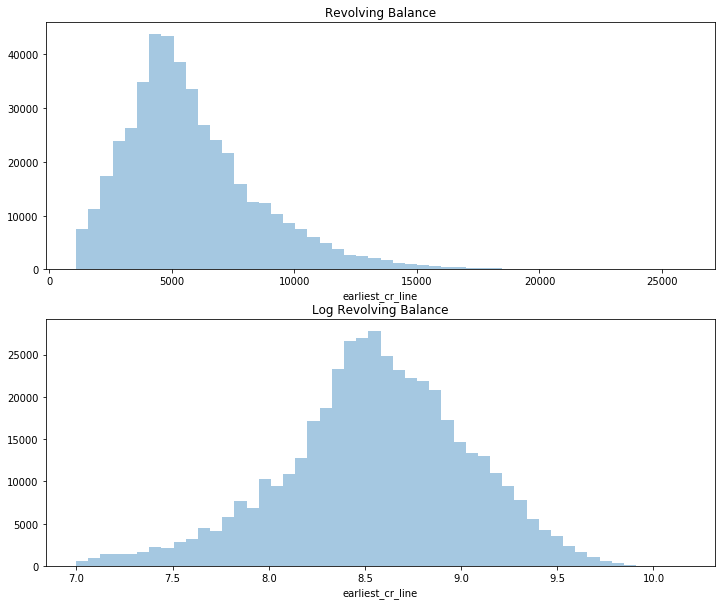

In [14]:
plt.figure(figsize=(12,10))

plt.subplot(2,1,1)
plt.title('Revolving Balance')
sns.distplot(loan.earliest_cr_line, kde=False)

plt.subplot(2,1,2)
plt.title('Log Revolving Balance')
sns.distplot(np.log(loan.earliest_cr_line), kde=False)

plt.show()

In [15]:
loan['ln_earliest_cr_line'] = np.log(loan.earliest_cr_line)

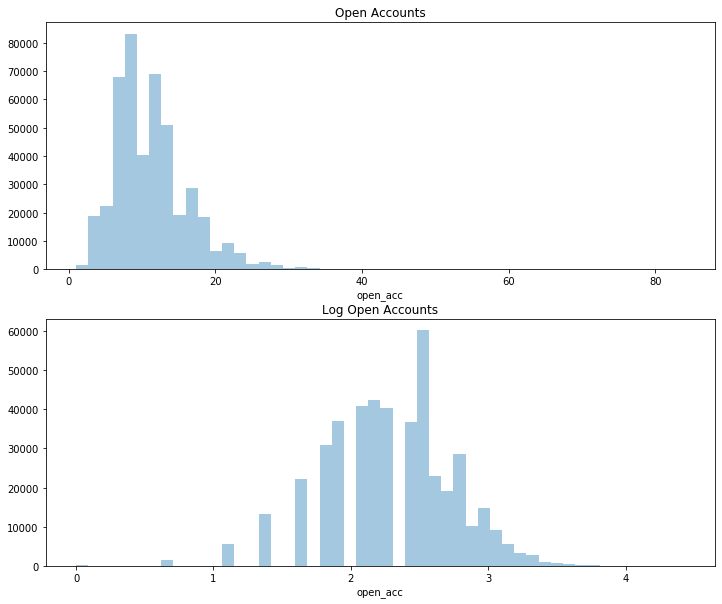

In [16]:
plt.figure(figsize=(12,10))

plt.subplot(2,1,1)
plt.title('Open Accounts')
sns.distplot(loan.open_acc, kde=False)

plt.subplot(2,1,2)
plt.title('Log Open Accounts')
sns.distplot(np.log(loan.open_acc), kde=False)

plt.show()

In [17]:
loan['ln_open_acc'] = np.log(loan.open_acc)

For certain discrete variables, such as number of delinquencies in the last two years, the effect of going from 0 to 1 should be drastically more than going from 1 to 2. I created a dummy variable if this is greater than or equal to 1 to reflect this.

In [18]:
loan.rename(columns = {'delinq_2yrs': 'num_delinq_2yrs'}, inplace=True)
loan['delinq_2yrs'] = (loan['num_delinq_2yrs'] >= 1)

loan.rename(columns = {'pub_rec': 'num_pub_rec'}, inplace=True)
loan['pub_rec'] = (loan['num_pub_rec'] >= 1)

loan.rename(columns = {'inq_last_6mths': 'num_inq_last_6mths'}, inplace=True)
loan['inq_last_6mths'] = (loan['num_inq_last_6mths'] >= 1)

Visualizing the final selection of transformed variables:

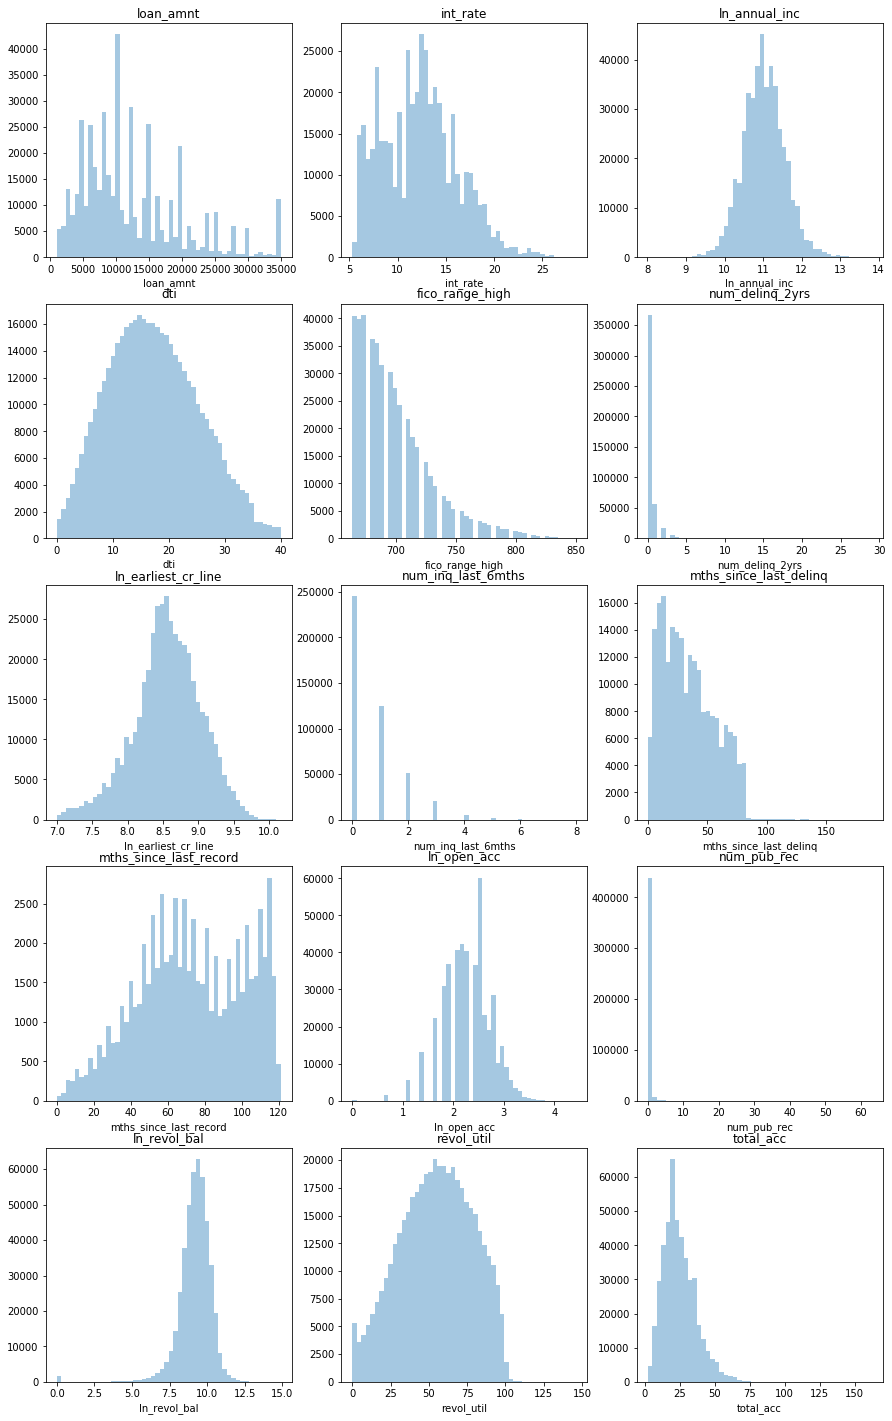

In [19]:
col_list = ['loan_amnt', 'int_rate', 'ln_annual_inc', 'dti', 'fico_range_high', 'num_delinq_2yrs', 'ln_earliest_cr_line', 'num_inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'ln_open_acc', 'num_pub_rec', 'ln_revol_bal', 'revol_util', 'total_acc']

plt.figure(figsize=(15,25))

for i in range(len(col_list)):
    plt.subplot(5,3,i+1)
    plt.title(col_list[i])
    sns.distplot(loan[col_list[i]].dropna(), kde=False)
    
plt.show()

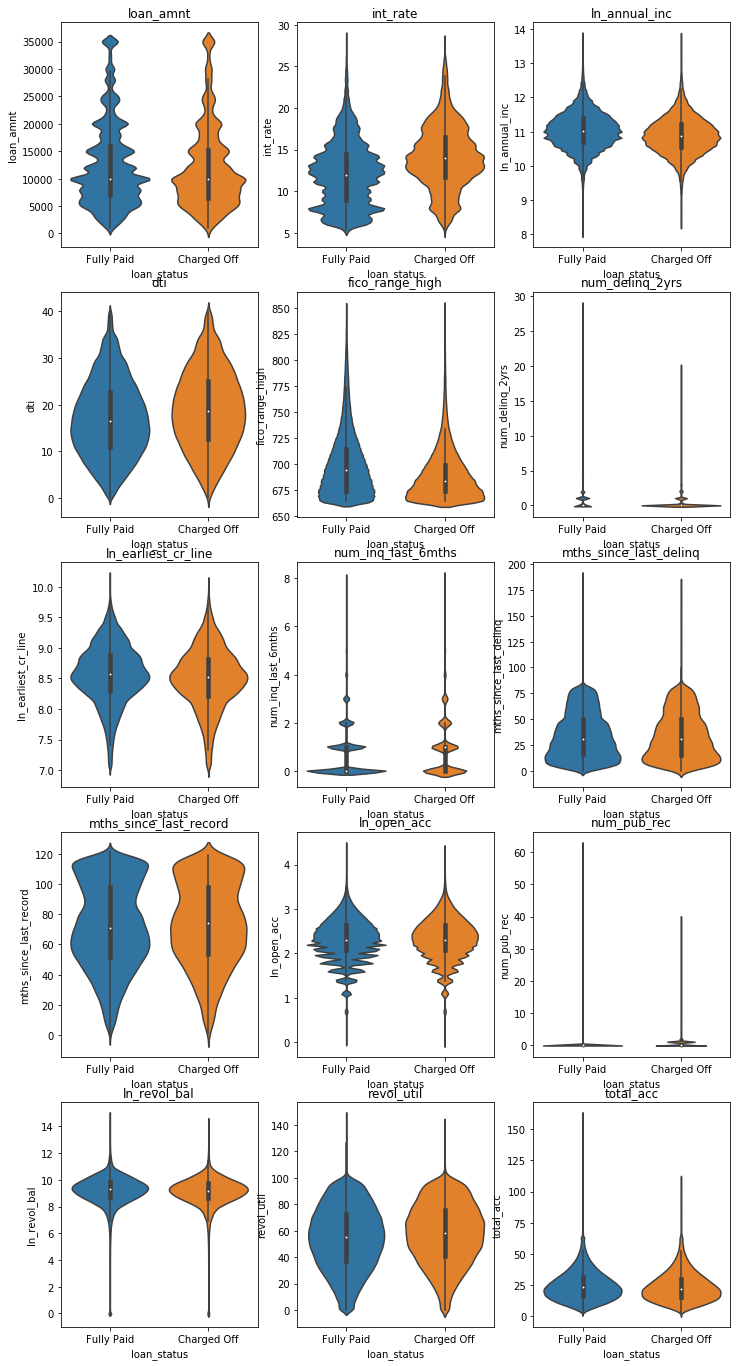

In [20]:
len(col_list)


plt.figure(figsize=(12,24))

for i in range(15):
    plt.subplot(5,3,i+1)
    plt.title(col_list[i])
    sns.violinplot(loan.loan_status, loan[col_list[i]])
    
plt.show()

There are several notable cases where the distribution for fully paid and charged off loans is different. Interest rates skew higher for loans that are charged off (this makes sense, and means that interest that Lending Club is choosing to charge is at partially correct). Distributions of credit score and income is higher for borrowers who eventually pay their loans back. Eventual defaulters have more debt and more recent inquiries.

None of this is particularly surprising. The correlation matrix is a little more interesting. We should be making note of factors that have a high correlation with the interest rate or borrower's credit score, but a low correlation with our target (or vice versa). These could potentially be factors that our models can take advantage of to identify underpriced assets to invest in.

In [21]:
col_list_target = ['target', 'loan_amnt', 'int_rate', 'annual_inc', 'dti', 'fico_range_high', 'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc']

loan['target'] = loan['loan_status'] == 'Fully Paid'

loan[col_list_target].corr()

,target,loan_amnt,int_rate,annual_inc,dti,fico_range_high,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc
target,1.000000,0.018977,-0.181028,0.071013,-0.079969,0.119160,-0.012128,0.040125,-0.054949,0.004404,-0.014171,-0.009988,-0.024995,0.032147,-0.047865,0.023550
loan_amnt,0.018977,1.000000,-0.087604,0.458126,0.004443,0.133288,0.010480,0.175234,-0.032888,-0.040423,-0.022335,0.193982,-0.109532,0.341827,0.088974,0.211682
int_rate,-0.181028,-0.087604,1.000000,-0.153823,0.142246,-0.518897,0.075191,-0.145474,0.229255,-0.031366,-0.020437,-0.054992,0.090987,-0.081613,0.294227,-0.114398
annual_inc,0.071013,0.458126,-0.153823,1.000000,-0.225550,0.123576,0.072153,0.205718,0.034665,-0.072626,-0.134928,0.188490,-0.045375,0.382658,0.041728,0.263530
dti,-0.079969,0.004443,0.142246,-0.225550,1.000000,-0.098505,0.000883,0.045396,0.001660,0.001823,0.053243,0.291104,-0.039534,0.127164,0.177897,0.214867
fico_range_high,0.119160,0.133288,-0.518897,0.123576,-0.098505,1.000000,-0.200277,0.096309,-0.081125,0.080915,0.241018,0.019051,-0.236548,0.057973,-0.456832,0.028497
delinq_2yrs,-0.012128,0.010480,0.075191,0.072153,0.000883,-0.200277,1.000000,0.109221,0.015569,-0.777508,-0.071806,0.060667,-0.026619,-0.020957,-0.017240,0.128264
earliest_cr_line,0.040125,0.175234,-0.145474,0.205718,0.045396,0.096309,0.109221,1.000000,-0.005708,-0.039300,-0.145586,0.147573,0.110163,0.206772,-0.006758,0.309766
inq_last_6mths,-0.054949,-0.032888,0.229255,0.034665,0.001660,-0.081125,0.015569,-0.005708,1.000000,0.013717,-0.072127,0.108106,0.056922,-0.020123,-0.073117,0.122318
mths_since_last_delinq,0.004404,-0.040423,-0.031366,-0.072626,0.001823,0.080915,-0.777508,-0.039300,0.013717,1.000000,-0.045317,-0.054391,0.118374,-0.029659,0.016591,-0.058660


FICO range is the factor that stands out as the highest disparity between correlation with interest rate and target. While it is still one of the factors most correlated with repayment, ist is within the neighborhood of other factors such as annual income and DTI. However, the correlation with interest rate is more than 3 times as much. Inquiries in the last 6 months and revolving utilization stands out for similar reasons, although the disparity is even greater. 

In [22]:
# Separate into a train and test dataset, and definte a separate dataset for walk-forward testing
train = loan[loan.issue_d < datetime.date(2014, 1, 1)]
test = loan[(loan.issue_d >= datetime.date(2014, 1, 1)) & (loan.issue_d < datetime.date(2015, 1, 1))]
wf = loan[(loan.issue_d >= datetime.date(2015, 1, 1)) & (loan.issue_d < datetime.date(2015, 7, 1))]

print('Training data sample size: {}'.format(train.shape[0]))
print('Test data sample size: {}'.format(test.shape[0]))
print('Walk-forward data sample size: {}'.format(wf.shape[0]))

Training data sample size: 166313
Test data sample size: 162462
Walk-forward data sample size: 120711


In [23]:
import statsmodels.api as sm

y = train['target']
X1 = train[['loan_amnt', 'ln_annual_inc', 'dti', 'fico_range_high', 'delinq_2yrs', 'num_delinq_2yrs', 'ln_earliest_cr_line', 'inq_last_6mths', 'num_inq_last_6mths', 'ln_open_acc', 'pub_rec', 'num_pub_rec', 'ln_revol_bal', 'revol_util', 'total_acc']]
X2 = pd.concat([X1, train.int_rate, pd.get_dummies(train.grade)], axis=1)
X3 = pd.concat([X1, train.int_rate, pd.get_dummies(train.sub_grade)], axis=1)
X1 = sm.add_constant(X1)

### Logistic Regression

The first model that is used to predict loan compliance is a logistic regression. 

One nice thing about the logit model is that it gives us parameter estimates. Some "black box," models don't actually tell us how it uses the factors inputted. A logistic regression gives us an estimate of how much a unit change in a certain factor affects our target. For example, in our first model, a 1-unit change in ln_annual_inc creates a 6.2% change in the likelihood of the loan being compliant.

I built 3 logistic regression models. The first does not consider interest rate or loan grade. The second adds interest rate and grade (all loans are graded on a scale of A-G, depending on a loan's desirability), and the third adds subgrade (all grades are subdivided into 5 different levels, for example A1-A5).

Originally my prediction was that utilizing interest rate and grade in our models would increase accuracy under traditional metrics, but wouldn't aid our ability to "beat," the market, since we're including as a factor the rating system that we are trying to gain an edge on (more on that below). This did not end up being correct. Including interest rate and grade improved accuracy measures but also resulted in better returns in out-of-sample testing. Adding in subgrade did not substantially increase accuracy, but did take much longer to run. Additionally, our sample size of G-rated loans is very small (around 200), so our subgrade-dependent model is going to be fairly prone to overfitting for this subset of loans.

In [24]:
import statsmodels.discrete as smd

logit = smd.discrete_model.Logit(y, X1.astype(float)).fit()
logit_me = logit.get_margeff()
logit_me.summary()

Optimization terminated successfully.
         Current function value: 0.359305
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:                 target
Method:                          dydx
At:                           overall
=======================================================================================
                         dy/dx    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
loan_amnt           -2.459e-06   1.38e-07    -17.878      0.000   -2.73e-06   -2.19e-06
ln_annual_inc           0.0621      0.002     29.539      0.000       0.058       0.066
dti                    -0.0015      0.000    -11.829      0.000      -0.002      -0.001
fico_range_high         0.0012    3.8e-05     32.077      0.000       0.001       0.001
delinq_2yrs             0.0088      0.004      2.480      0.013       0.002       0.016
num_delinq_2yrs        -0.0017      0.002     -0.955      0.340      -0.005       0.002
ln_earliest_cr_line    -0.0023      0.002     -1.224      0.221      -0.006       0.001
inq_last_6mths         -0.0065      0.003     -2.528      0.011      -0.012      -0.001
num_inq_last_6mths     -0.0171      0.001    -14.271      0.000      -0.020      -0.015
ln_open_acc            -0.0215      0.003     -8.045      0.000      -0.027      -0.016
pub_rec                 0.0133      0.005      2.894      0.004       0.004       0.022
num_pub_rec          1.869e-05      0.003      0.006      0.995      -0.006       0.006
ln_revol_bal            0.0132      0.001     14.761      0.000       0.011       0.015
revol_util             -0.0004   4.85e-05     -9.023      0.000      -0.001      -0.000
total_acc               0.0009      0.000      7.896      0.000       0.001       0.001
=======================================================================================
"""

In [25]:
logit2 = smd.discrete_model.Logit(y, X2.astype(float)).fit()
logit2_me = logit2.get_margeff()
logit2_me.summary()

Optimization terminated successfully.
         Current function value: 0.356435
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:                 target
Method:                          dydx
At:                           overall
=======================================================================================
                         dy/dx    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
loan_amnt           -1.867e-06   1.36e-07    -13.773      0.000   -2.13e-06    -1.6e-06
ln_annual_inc           0.0576      0.002     27.607      0.000       0.053       0.062
dti                    -0.0012      0.000     -9.397      0.000      -0.001      -0.001
fico_range_high         0.0005   4.56e-05     10.062      0.000       0.000       0.001
delinq_2yrs             0.0079      0.004      2.223      0.026       0.001       0.015
num_delinq_2yrs        -0.0009      0.002     -0.513      0.608      -0.004       0.003
ln_earliest_cr_line    -0.0037      0.002     -1.957      0.050      -0.007     6.2e-06
inq_last_6mths          0.0011      0.003      0.421      0.674      -0.004       0.006
num_inq_last_6mths     -0.0119      0.001     -9.868      0.000      -0.014      -0.010
ln_open_acc            -0.0206      0.003     -7.772      0.000      -0.026      -0.015
pub_rec                 0.0092      0.005      1.826      0.068      -0.001       0.019
num_pub_rec             0.0017      0.004      0.456      0.649      -0.006       0.009
ln_revol_bal            0.0087      0.001      9.408      0.000       0.007       0.010
revol_util             -0.0002   4.88e-05     -3.916      0.000      -0.000   -9.55e-05
total_acc               0.0007      0.000      6.056      0.000       0.000       0.001
int_rate               -0.0076      0.001    -10.963      0.000      -0.009      -0.006
A                      -0.5860      0.042    -14.012      0.000      -0.668      -0.504
B                      -0.5968      0.042    -14.371      0.000      -0.678      -0.515
C                      -0.6046      0.042    -14.421      0.000      -0.687      -0.522
D                      -0.6074      0.043    -14.236      0.000      -0.691      -0.524
E                      -0.5986      0.044    -13.729      0.000      -0.684      -0.513
F                      -0.5958      0.045    -13.262      0.000      -0.684      -0.508
G                      -0.6173      0.053    -11.675      0.000      -0.721      -0.514
=======================================================================================
"""

In [26]:
logit3 = smd.discrete_model.Logit(y, X3.astype(float)).fit()
logit3_me = logit3.get_margeff()
logit3_me.summary()

         Current function value: 0.356164
         Iterations: 35


<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:                 target
Method:                          dydx
At:                           overall
=======================================================================================
                         dy/dx    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
loan_amnt           -1.786e-06   1.36e-07    -13.139      0.000   -2.05e-06   -1.52e-06
ln_annual_inc           0.0574      0.002     27.554      0.000       0.053       0.062
dti                    -0.0012      0.000     -9.379      0.000      -0.001      -0.001
fico_range_high         0.0004   4.68e-05      8.173      0.000       0.000       0.000
delinq_2yrs             0.0079      0.004      2.223      0.026       0.001       0.015
num_delinq_2yrs        -0.0010      0.002     -0.535      0.592      -0.004       0.003
ln_earliest_cr_line    -0.0046      0.002     -2.418      0.016      -0.008      -0.001
inq_last_6mths          0.0018      0.003      0.688      0.492      -0.003       0.007
num_inq_last_6mths     -0.0117      0.001     -9.677      0.000      -0.014      -0.009
ln_open_acc            -0.0215      0.003     -8.106      0.000      -0.027      -0.016
pub_rec                 0.0091      0.005      1.799      0.072      -0.001       0.019
num_pub_rec             0.0017      0.004      0.464      0.643      -0.006       0.009
ln_revol_bal            0.0082      0.001      8.902      0.000       0.006       0.010
revol_util             -0.0002   4.89e-05     -3.504      0.000      -0.000   -7.54e-05
total_acc               0.0007      0.000      6.117      0.000       0.000       0.001
int_rate               -0.0036      0.001     -3.128      0.002      -0.006      -0.001
A1                     -0.5055      0.044    -11.454      0.000      -0.592      -0.419
A2                     -0.5248      0.043    -12.122      0.000      -0.610      -0.440
A3                     -0.5403      0.043    -12.593      0.000      -0.624      -0.456
A4                     -0.5571      0.042    -13.125      0.000      -0.640      -0.474
A5                     -0.5650      0.042    -13.341      0.000      -0.648      -0.482
B1                     -0.5699      0.042    -13.453      0.000      -0.653      -0.487
B2                     -0.5714      0.042    -13.472      0.000      -0.655      -0.488
B3                     -0.5765      0.043    -13.561      0.000      -0.660      -0.493
B4                     -0.5831      0.043    -13.657      0.000      -0.667      -0.499
B5                     -0.5907      0.043    -13.777      0.000      -0.675      -0.507
C1                     -0.5924      0.043    -13.766      0.000      -0.677      -0.508
C2                     -0.5964      0.043    -13.772      0.000      -0.681      -0.512
C3                     -0.6077      0.044    -13.960      0.000      -0.693      -0.522
C4                     -0.6104      0.044    -13.957      0.000      -0.696      -0.525
C5                     -0.6041      0.044    -13.692      0.000      -0.691      -0.518
D1                     -0.6180      0.044    -13.930      0.000      -0.705      -0.531
D2                     -0.6159      0.045    -13.775      0.000      -0.704      -0.528
D3                     -0.6157      0.045    -13.676      0.000      -0.704      -0.527
D4                     -0.6231      0.045    -13.766      0.000      -0.712      -0.534
D5                     -0.6109      0.046    -13.356      0.000      -0.701      -0.521
E1                     -0.6147      0.046    -13.310      0.000      -0.705      -0.524
E2                     -0.6233      0.047    -13.361      0.000      -0.715      -0.532
E3                     -0.6136      0.047    -13.008      0.000      -0.706      -0.521
E4                     -0.6209      0.048    -12.993      0.000   

In [27]:
X1_test = test[['loan_amnt', 'ln_annual_inc', 'dti', 'fico_range_high', 'delinq_2yrs', 'num_delinq_2yrs', 'ln_earliest_cr_line', 'inq_last_6mths', 'num_inq_last_6mths', 'ln_open_acc', 'pub_rec', 'num_pub_rec', 'ln_revol_bal', 'revol_util', 'total_acc']]
X2_test = pd.concat([X1_test, test.int_rate, pd.get_dummies(test.grade)], axis=1)
X3_test = pd.concat([X1_test, test.int_rate, pd.get_dummies(test.sub_grade)], axis=1)
X1_test = sm.add_constant(X1_test)
y_test = test['target']

test['pred_lg1'] = logit.predict(X1_test.astype(float))
test['pred_lg2'] = logit2.predict(X2_test.astype(float))
test['pred_lg3'] = logit3.predict(X3_test.astype(float))

def total_int_paid(n, i):
    ii = i/12
    return n*(ii * (1 + ii) ** n) / ((1+ii)**n - 1)-1

test['total_int_paid'] = test.apply(lambda x: total_int_paid(36, x['int_rate']/100), axis=1)

test['ev_lg1'] = test['pred_lg1'] * test['total_int_paid'] - (1 - test['pred_lg1']) * .37
test['ev_lg2'] = test['pred_lg2'] * test['total_int_paid'] - (1 - test['pred_lg2']) * .37
test['ev_lg3'] = test['pred_lg3'] * test['total_int_paid'] - (1 - test['pred_lg3']) * .37

In [28]:
from sklearn.metrics import roc_auc_score

print('ROC-AUC score, Logistic Regression Model 1: {}'.format(roc_auc_score(test.target, test.pred_lg1)))
print('ROC-AUC score, Logistic Regression Model 2: {}'.format(roc_auc_score(test.target, test.pred_lg2)))
print('ROC-AUC score, Logistic Regression Model 3: {}'.format(roc_auc_score(test.target, test.pred_lg3)))

ROC-AUC score, Logistic Regression Model 1: 0.6442413687245739
ROC-AUC score, Logistic Regression Model 2: 0.6705138497793081
ROC-AUC score, Logistic Regression Model 3: 0.6709374661893023


There are factors that make this problem distinct from a more typical classification problem: the interest rate. Everyone, for the most part, knows factors that make borrowers more or less desireable to loan to. As a result, the price of credit (interest charged) offered to desireable borrowers is much lower. 

I needed to find a way to measure how well a model was doing in predicting a loan's likelihood of repayment, relative to the grade or interest rate. If a model is not able to determine the best loans within a class or among similarly-priced loans, it won't be useful towards our end goal of higher investment returns.

To illustrate this point, imagine a simple model that will be relatively accurate, yet ineffective; A- and B-grade loans will default the least. Followed by C-grade, D-grade, etc. This will be reasonably accurate, but since the A- and B-grade loans also have the lowest interest rates, this model will not help us achieve returns better than had we not considered it. 

The first method I used is to graph predicted compliance against actual compliance, separated by loan grade. This is meant to show how well our model predicts repayment, among loans of the same grade (and therefore, comprable interest rates). A smooth graph close to the orange line reflects a model with accurate probabilities, that we can trust to select the best investments within a class. Alternatively, a flat line would indicate our predictions have no predictive power within classes. It is important to note that some graphs will suffer from sample size issues towards the ends of the chart.

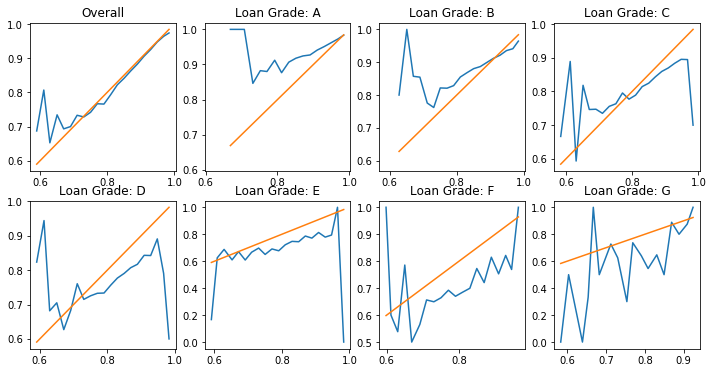

In [29]:
def graph_by_grade(predictions, grade, target, filename):
    pred = []
    act = []
    letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
    
    plt.figure(figsize=(12,6))
    plt.subplot(2,4,1)
    plt.title("Overall")
    
    for i in range(21):
        
        lb = .58 + i*.02
        ub = .58 + (i+1)*.02
        sub = ((predictions >= lb)&(predictions < ub))
        pred_compliance = predictions[sub].mean()
        act_compliance = target[sub].mean()
        pred.append(pred_compliance)
        act.append(act_compliance)

    plt.plot(pred, act)
    plt.plot(pred, pred)

    for letter in range(7):
        
        pred = []
        act = []
        ss = []
        
        for i in range(21):
            lb = .58 + i*.02
            ub = .58 + (i+1)*.02
            sub = ((predictions >= lb)&(predictions < ub)&(grade==letters[letter]))
            pred_compliance = predictions[sub].mean()
            act_compliance = target[sub].mean()
            pred.append(pred_compliance)
            act.append(act_compliance)

        plt.subplot(2,4,letter+2)
        plt.title('Loan Grade: {}'.format(letters[letter]))
        plt.plot(pred, act)
        plt.plot(pred, pred)
    
    plt.savefig(filename)
    plt.show()
    
graph_by_grade(test.pred_lg1, test.grade, test.target, 'logit1.png')

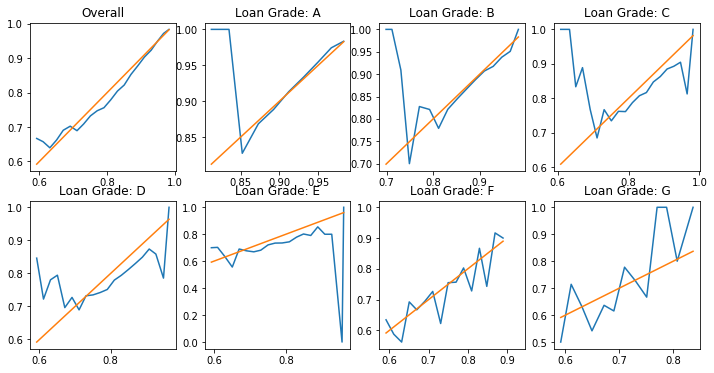

In [30]:
graph_by_grade(test.pred_lg2, test.grade, test.target, 'logit2.png')

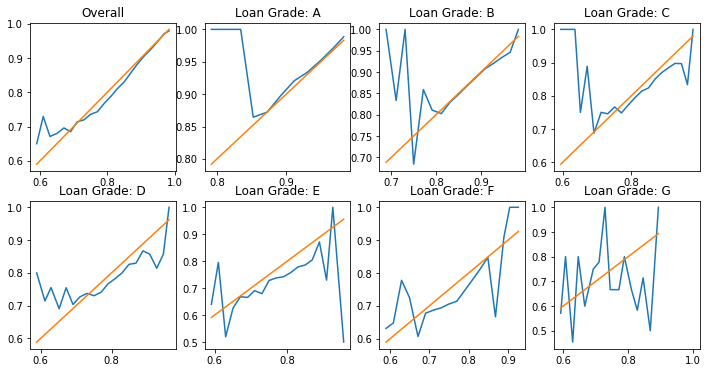

In [31]:
graph_by_grade(test.pred_lg3, test.grade, test.target, 'logit3.png')

The second, and more practical, method is to test out-of-sample returns of a portfolio recommended by the model. This is the end goal that a user of our model would be interested in; better returns. Our function displays the average return for a loan in each class, then the average return for the top 20%, 10%, and 5% of loans as predicted by our model. We use a measure of "expected value," instead of the raw probability of repayment. 


Again, this will test the model's ability to find the most valuable loans (as opposed to most likely to be repaid), which will involve both the predicted probability of repayment and the interest rate.

In [32]:
test['pct_return'] = (test.total_pymnt - test.funded_amnt) / test.funded_amnt
   
def returns_by_grade(metric, grade, returns, thresh = [80, 90, 95]):
    for letter in ['A', 'B', 'C', 'D', 'E', 'F', 'G']:
        
        cutoffs = [np.percentile(metric[grade == letter], q=x) for x in thresh]
        
        print('--------------  ' + letter + '  --------------')
        print('')
    
        print('Naive Returns:             {}%'.format(round(returns[grade==letter].mean()*100, 2)))
        print('')
        
        for c in range(len(thresh)):
            print('{} Percent Cutoff:         {}%'.format(thresh[c], round(returns[(grade == letter) & (metric >= cutoffs[c])].mean()*100,2)))
            
        print('')
        
returns_by_grade(test.ev_lg1, test.grade, test.pct_return)

--------------  A  --------------

Naive Returns:             7.45%

80 Percent Cutoff:         8.25%
90 Percent Cutoff:         8.39%
95 Percent Cutoff:         8.65%

--------------  B  --------------

Naive Returns:             9.54%

80 Percent Cutoff:         11.04%
90 Percent Cutoff:         11.35%
95 Percent Cutoff:         11.7%

--------------  C  --------------

Naive Returns:             9.31%

80 Percent Cutoff:         11.35%
90 Percent Cutoff:         11.57%
95 Percent Cutoff:         11.46%

--------------  D  --------------

Naive Returns:             9.33%

80 Percent Cutoff:         12.67%
90 Percent Cutoff:         13.33%
95 Percent Cutoff:         14.13%

--------------  E  --------------

Naive Returns:             9.5%

80 Percent Cutoff:         12.57%
90 Percent Cutoff:         13.05%
95 Percent Cutoff:         11.37%

--------------  F  --------------

Naive Returns:             12.17%

80 Percent Cutoff:         16.7%
90 Percent Cutoff:         17.72%
95 Perce

In [33]:
returns_by_grade(test.ev_lg2, test.grade, test.pct_return)

--------------  A  --------------

Naive Returns:             7.45%

80 Percent Cutoff:         8.44%
90 Percent Cutoff:         8.62%
95 Percent Cutoff:         9.07%

--------------  B  --------------

Naive Returns:             9.54%

80 Percent Cutoff:         11.11%
90 Percent Cutoff:         11.57%
95 Percent Cutoff:         12.17%

--------------  C  --------------

Naive Returns:             9.31%

80 Percent Cutoff:         11.52%
90 Percent Cutoff:         11.99%
95 Percent Cutoff:         11.98%

--------------  D  --------------

Naive Returns:             9.33%

80 Percent Cutoff:         12.99%
90 Percent Cutoff:         13.79%
95 Percent Cutoff:         14.82%

--------------  E  --------------

Naive Returns:             9.5%

80 Percent Cutoff:         12.74%
90 Percent Cutoff:         13.13%
95 Percent Cutoff:         14.81%

--------------  F  --------------

Naive Returns:             12.17%

80 Percent Cutoff:         16.88%
90 Percent Cutoff:         16.53%
95 Per

In [34]:
returns_by_grade(test.ev_lg3, test.grade, test.pct_return)

--------------  A  --------------

Naive Returns:             7.45%

80 Percent Cutoff:         8.45%
90 Percent Cutoff:         8.66%
95 Percent Cutoff:         9.14%

--------------  B  --------------

Naive Returns:             9.54%

80 Percent Cutoff:         11.22%
90 Percent Cutoff:         11.62%
95 Percent Cutoff:         12.1%

--------------  C  --------------

Naive Returns:             9.31%

80 Percent Cutoff:         11.68%
90 Percent Cutoff:         11.93%
95 Percent Cutoff:         12.24%

--------------  D  --------------

Naive Returns:             9.33%

80 Percent Cutoff:         12.88%
90 Percent Cutoff:         14.1%
95 Percent Cutoff:         14.84%

--------------  E  --------------

Naive Returns:             9.5%

80 Percent Cutoff:         12.95%
90 Percent Cutoff:         13.64%
95 Percent Cutoff:         13.6%

--------------  F  --------------

Naive Returns:             12.17%

80 Percent Cutoff:         18.36%
90 Percent Cutoff:         20.29%
95 Percen

### Random Forests

Random forests are known as being very effective models for classification. Originally, my intuition was that the derived probabilities would not be as accurate as a logistic regression. For our application, this is important. However, this turned out to not be the case.

In [35]:
# X1 and X1 test data frames have a constant/intercept term, which is not useful in a random forest model
X1 = train[['loan_amnt', 'ln_annual_inc', 'dti', 'fico_range_high', 'delinq_2yrs', 'num_delinq_2yrs', 'ln_earliest_cr_line', 'inq_last_6mths', 'num_inq_last_6mths', 'ln_open_acc', 'pub_rec', 'num_pub_rec', 'ln_revol_bal', 'revol_util', 'total_acc']]
X1_test = test[['loan_amnt', 'ln_annual_inc', 'dti', 'fico_range_high', 'delinq_2yrs', 'num_delinq_2yrs', 'ln_earliest_cr_line', 'inq_last_6mths', 'num_inq_last_6mths', 'ln_open_acc', 'pub_rec', 'num_pub_rec', 'ln_revol_bal', 'revol_util', 'total_acc']]

I develop 3 different random forest models. The first (as above) does not consider interest rate and loan grade while fitting. The second adds in these factors. The third adjusts for an unbalanced dataset (about 1/8 of loans default), using a synthetic data method (ADASYN) to create artificial data. Pure oversampling, where a scientist simply duplicates minority class data, can lead some machine learning models to overfit. This method reduces that likelihood by generating synthetic data that is similar to existing minority class data, but not exactly duplicated.

Additionally, while not included in this notebook, I did use random search to determine optimal hyperparameters.

In [36]:
from sklearn import ensemble

# We used Random Search in a separate notebook to find optimal hyperparameters
rf1 = ensemble.RandomForestClassifier(n_estimators=500, max_features=3, max_depth=10)
rf1.fit(X1, y)
test['pred_rf1'] = [x[1] for x in rf1.predict_proba(X1_test)]

In [37]:
rf2 = ensemble.RandomForestClassifier(n_estimators=500, max_features=4, max_depth=10)
rf2.fit(X2, y)
test['pred_rf2'] = [x[1] for x in rf2.predict_proba(X2_test)]

In [38]:
from imblearn.over_sampling import ADASYN

sampler = ADASYN(n_neighbors=4)
X2_rs, y_rs = sampler.fit_sample(X2, y)

print("Original Sample - Paid: {}".format(sum(y == True)))
print("Original Sample - Default: {}".format(sum(y == False)))
print("Rebalanced Sample - Paid: {}".format(sum(y_rs == True)))
print("Rebalanced Sample - Paid: {}".format(sum(y_rs == False)))

Using TensorFlow backend.


Original Sample - Paid: 145709
Original Sample - Default: 20604
Rebalanced Sample - Paid: 145709
Rebalanced Sample - Paid: 143189


In [39]:
X2_rs.head()

,loan_amnt,ln_annual_inc,dti,fico_range_high,delinq_2yrs,num_delinq_2yrs,ln_earliest_cr_line,inq_last_6mths,num_inq_last_6mths,ln_open_acc,...,revol_util,total_acc,int_rate,A,B,C,D,E,F,G
0,5000.0,10.085809,27.65,739.0,False,0.0,9.193194,True,1.0,1.098612,...,83.7,9.0,10.65,0,1,0,0,0,0,0
1,2400.0,9.413444,8.72,739.0,False,0.0,8.211211,True,2.0,0.693147,...,98.5,10.0,15.96,0,0,1,0,0,0,0
2,10000.0,10.803649,20.00,694.0,False,0.0,8.662505,True,1.0,2.302585,...,21.0,37.0,13.49,0,0,1,0,0,0,0
3,5000.0,10.491274,11.20,734.0,False,0.0,7.857868,True,3.0,2.197225,...,28.3,12.0,7.90,1,0,0,0,0,0,0
4,3000.0,10.778956,5.35,664.0,False,0.0,7.492760,True,2.0,1.386294,...,87.5,4.0,18.64,0,0,0,0,1,0,0


In [40]:
X2_rs.tail()

,loan_amnt,ln_annual_inc,dti,fico_range_high,delinq_2yrs,num_delinq_2yrs,ln_earliest_cr_line,inq_last_6mths,num_inq_last_6mths,ln_open_acc,...,revol_util,total_acc,int_rate,A,B,C,D,E,F,G
288893,12000.0,10.721476,12.033138,677.544055,False,0.0,8.330166,False,0.000000,2.437220,...,94.510351,26.708811,15.364019,0,0,0,0,0,0,0
288894,12000.0,10.585030,12.478702,679.000000,False,0.0,8.288739,True,0.314493,2.551060,...,93.168551,25.899274,16.444102,0,0,0,0,0,0,0
288895,12000.0,10.637686,12.323990,678.016218,False,0.0,8.302245,False,0.000000,2.502676,...,94.085404,26.803244,15.664315,0,0,0,0,0,0,0
288896,12000.0,11.100906,14.481763,679.000000,False,0.0,8.688281,False,0.000000,2.639057,...,94.219938,29.914110,15.321059,0,0,0,1,0,0,0
288897,12000.0,10.596389,12.436659,679.000000,False,0.0,8.292900,True,0.343792,2.542862,...,93.165621,25.796729,16.458458,0,0,0,0,0,0,0


In [41]:
rf3 = ensemble.RandomForestClassifier(n_estimators=500, max_features=4, max_depth=10)

rf3.fit(X2_rs, y_rs)

test['pred_rf3'] = [x[1] for x in rf3.predict_proba(X2_test)]

In [42]:
test['pred_rf3_adj'] = 7 * test.pred_rf3 / (1 + 6 * test.pred_rf3)

In [43]:
print('ROC-AUC score, Random Forest Model 1: {}'.format(roc_auc_score(test.target, test.pred_rf1)))
print('ROC-AUC score, Random Forest Model 2: {}'.format(roc_auc_score(test.target, test.pred_rf2)))
print('ROC-AUC score, Random Forest Model 3: {}'.format(roc_auc_score(test.target, test.pred_rf3)))

ROC-AUC score, Random Forest Model 1: 0.6465138459780233
ROC-AUC score, Random Forest Model 2: 0.6713872234726991
ROC-AUC score, Random Forest Model 3: 0.6537540212607115


In [44]:
test['ev_rf1'] = test['pred_rf1'] * test['total_int_paid'] - (1 - test['pred_rf1']) * .37
test['ev_rf2'] = test['pred_rf2'] * test['total_int_paid'] - (1 - test['pred_rf2']) * .37
test['ev_rf3'] = test['pred_rf3_adj'] * test['total_int_paid'] - (1 - test['pred_rf3_adj']) * .37

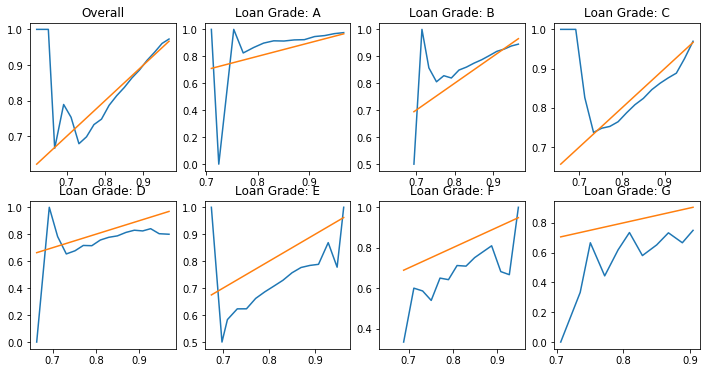

In [45]:
graph_by_grade(test.pred_rf1, test.grade, test.target, 'rf1.png')

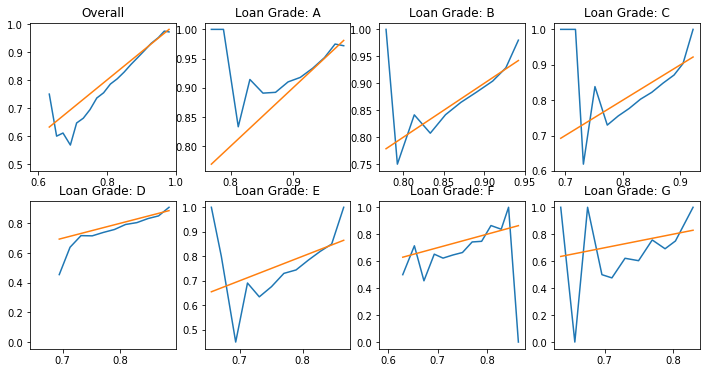

In [46]:
graph_by_grade(test.pred_rf2, test.grade, test.target, 'rf2.png')

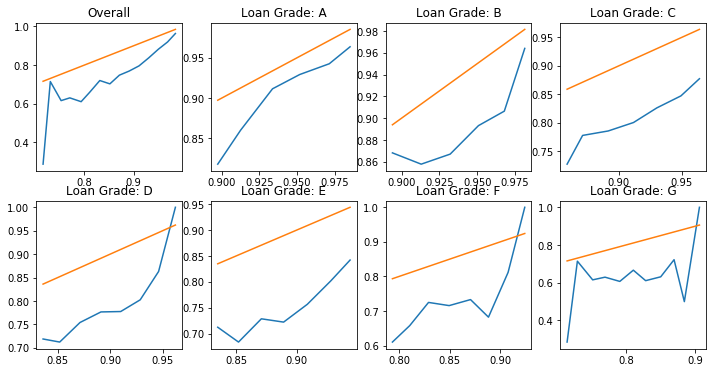

In [47]:
graph_by_grade(test.pred_rf3_adj, test.grade, test.target, 'rf3.png')

In [48]:
returns_by_grade(test.ev_rf1, test.grade, test.pct_return)

--------------  A  --------------

Naive Returns:             7.45%

80 Percent Cutoff:         8.37%
90 Percent Cutoff:         8.52%
95 Percent Cutoff:         8.99%

--------------  B  --------------

Naive Returns:             9.54%

80 Percent Cutoff:         11.05%
90 Percent Cutoff:         11.6%
95 Percent Cutoff:         11.79%

--------------  C  --------------

Naive Returns:             9.31%

80 Percent Cutoff:         11.39%
90 Percent Cutoff:         11.95%
95 Percent Cutoff:         11.68%

--------------  D  --------------

Naive Returns:             9.33%

80 Percent Cutoff:         12.04%
90 Percent Cutoff:         13.44%
95 Percent Cutoff:         13.01%

--------------  E  --------------

Naive Returns:             9.5%

80 Percent Cutoff:         12.01%
90 Percent Cutoff:         11.52%
95 Percent Cutoff:         12.04%

--------------  F  --------------

Naive Returns:             12.17%

80 Percent Cutoff:         15.43%
90 Percent Cutoff:         17.42%
95 Perc

In [49]:
returns_by_grade(test.ev_rf2, test.grade, test.pct_return)

--------------  A  --------------

Naive Returns:             7.45%

80 Percent Cutoff:         8.43%
90 Percent Cutoff:         8.92%
95 Percent Cutoff:         9.26%

--------------  B  --------------

Naive Returns:             9.54%

80 Percent Cutoff:         11.27%
90 Percent Cutoff:         11.96%
95 Percent Cutoff:         12.72%

--------------  C  --------------

Naive Returns:             9.31%

80 Percent Cutoff:         11.77%
90 Percent Cutoff:         12.34%
95 Percent Cutoff:         12.68%

--------------  D  --------------

Naive Returns:             9.33%

80 Percent Cutoff:         12.78%
90 Percent Cutoff:         14.27%
95 Percent Cutoff:         14.28%

--------------  E  --------------

Naive Returns:             9.5%

80 Percent Cutoff:         13.67%
90 Percent Cutoff:         13.86%
95 Percent Cutoff:         15.61%

--------------  F  --------------

Naive Returns:             12.17%

80 Percent Cutoff:         19.4%
90 Percent Cutoff:         20.02%
95 Perc

In [50]:
returns_by_grade(test.ev_rf3, test.grade, test.pct_return)

--------------  A  --------------

Naive Returns:             7.45%

80 Percent Cutoff:         8.45%
90 Percent Cutoff:         8.89%
95 Percent Cutoff:         9.24%

--------------  B  --------------

Naive Returns:             9.54%

80 Percent Cutoff:         10.98%
90 Percent Cutoff:         11.52%
95 Percent Cutoff:         12.03%

--------------  C  --------------

Naive Returns:             9.31%

80 Percent Cutoff:         11.09%
90 Percent Cutoff:         11.91%
95 Percent Cutoff:         12.69%

--------------  D  --------------

Naive Returns:             9.33%

80 Percent Cutoff:         12.27%
90 Percent Cutoff:         13.46%
95 Percent Cutoff:         14.75%

--------------  E  --------------

Naive Returns:             9.5%

80 Percent Cutoff:         11.84%
90 Percent Cutoff:         12.02%
95 Percent Cutoff:         11.39%

--------------  F  --------------

Naive Returns:             12.17%

80 Percent Cutoff:         12.53%
90 Percent Cutoff:         15.61%
95 Per

Our grade-ignorant model did substantially better than its logistic regression counterpart by all measures. Again, adding in interest rate and loan grade did increase our models predictive power, by traditional measures and investment returns. Our model using rebalanced data was not as effective. 

### Gradient Boosting

The last model I attempted was a gradient boosting classifier. Using random search to tune hyperparameterrs, there were many parameter combinations that scored very similarly. Some, like low learning rate, that consistently among our best parameter sets. Max features was a little more ambiguous, with some models with low max features, and some high all scoring very well. I build two models, one with a low parameter setting for max features, and one with high.

In [51]:
gb1 = ensemble.GradientBoostingClassifier(n_estimators=500, max_depth=2, learning_rate=.05, loss='exponential', max_features=3)
gb1.fit(X2, y)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.05, loss='exponential', max_depth=2,
                           max_features=3, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=500,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [52]:
test['pred_gb1'] = [x[1] for x in gb1.predict_proba(X2_test)]

In [53]:
gb2 = ensemble.GradientBoostingClassifier(n_estimators=500, max_depth=2, learning_rate=.05, loss='exponential', max_features=7)
gb2.fit(X2, y)
test['pred_gb2'] = [x[1] for x in gb2.predict_proba(X2_test)]

In [54]:
print('ROC-AUC score, Gradient Boosting Model 1: {}'.format(roc_auc_score(test.target, test.pred_gb1)))
print('ROC-AUC score, Gradient Boosting Model 2: {}'.format(roc_auc_score(test.target, test.pred_gb2)))

ROC-AUC score, Gradient Boosting Model 1: 0.6678441755261817
ROC-AUC score, Gradient Boosting Model 2: 0.6673082130676078


In [55]:
test['ev_gb1'] = test['pred_gb1'] * test['total_int_paid'] - (1 - test['pred_gb1']) * .37
test['ev_gb2'] = test['pred_gb2'] * test['total_int_paid'] - (1 - test['pred_gb2']) * .37

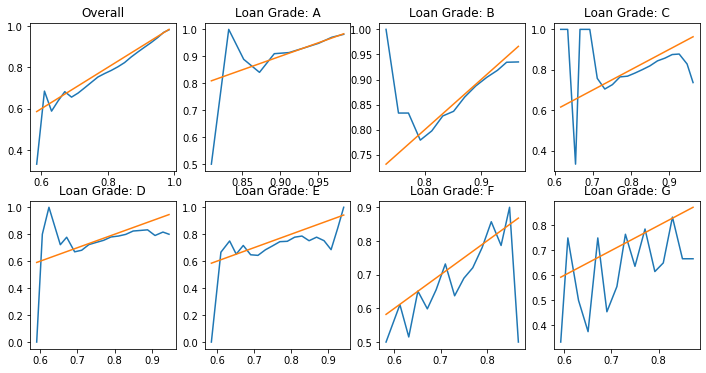

In [56]:
graph_by_grade(test.pred_gb1, test.grade, test.target, 'boosting1.png')

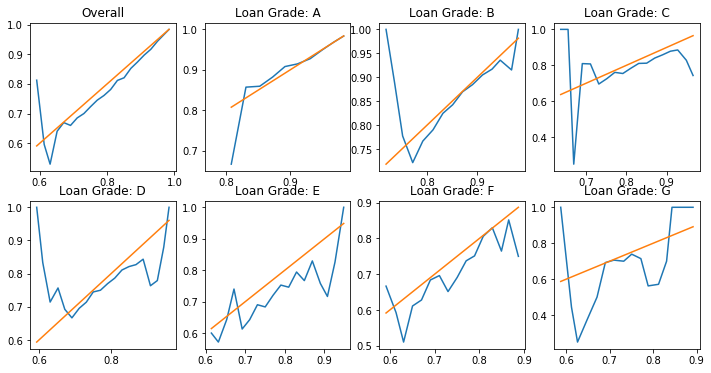

In [57]:
graph_by_grade(test.pred_gb2, test.grade, test.target, 'boosting2.png')

In [58]:
returns_by_grade(test.ev_gb1, test.grade, test.pct_return)

--------------  A  --------------

Naive Returns:             7.45%

80 Percent Cutoff:         8.4%
90 Percent Cutoff:         8.76%
95 Percent Cutoff:         9.16%

--------------  B  --------------

Naive Returns:             9.54%

80 Percent Cutoff:         11.3%
90 Percent Cutoff:         11.89%
95 Percent Cutoff:         12.37%

--------------  C  --------------

Naive Returns:             9.31%

80 Percent Cutoff:         11.53%
90 Percent Cutoff:         12.1%
95 Percent Cutoff:         12.1%

--------------  D  --------------

Naive Returns:             9.33%

80 Percent Cutoff:         13.13%
90 Percent Cutoff:         13.59%
95 Percent Cutoff:         14.02%

--------------  E  --------------

Naive Returns:             9.5%

80 Percent Cutoff:         12.72%
90 Percent Cutoff:         13.13%
95 Percent Cutoff:         11.31%

--------------  F  --------------

Naive Returns:             12.17%

80 Percent Cutoff:         19.27%
90 Percent Cutoff:         21.51%
95 Percent

In [59]:
returns_by_grade(test.ev_gb2, test.grade, test.pct_return)

--------------  A  --------------

Naive Returns:             7.45%

80 Percent Cutoff:         8.51%
90 Percent Cutoff:         8.69%
95 Percent Cutoff:         9.36%

--------------  B  --------------

Naive Returns:             9.54%

80 Percent Cutoff:         11.27%
90 Percent Cutoff:         12.0%
95 Percent Cutoff:         12.44%

--------------  C  --------------

Naive Returns:             9.31%

80 Percent Cutoff:         11.71%
90 Percent Cutoff:         12.09%
95 Percent Cutoff:         11.75%

--------------  D  --------------

Naive Returns:             9.33%

80 Percent Cutoff:         13.12%
90 Percent Cutoff:         13.39%
95 Percent Cutoff:         13.44%

--------------  E  --------------

Naive Returns:             9.5%

80 Percent Cutoff:         12.52%
90 Percent Cutoff:         12.58%
95 Percent Cutoff:         12.47%

--------------  F  --------------

Naive Returns:             12.17%

80 Percent Cutoff:         19.12%
90 Percent Cutoff:         18.83%
95 Perc

The results are decent, but not quite as good as random forests or a logistic regression.

### Walk-Forward Testing

The last test I ran was to run a simulation (on previously unseen data) of portfolios selected by each model. It's supposed to simulate the potential range of possibilities that could've occurred, had we invested using the model in early 2015.

In [60]:
wf['total_int_paid'] = wf.apply(lambda x: total_int_paid(36, x['int_rate']/100), axis=1)
wf['pct_return'] = (wf.total_pymnt - wf.funded_amnt) / wf.funded_amnt

X1_wf = wf[['loan_amnt', 'ln_annual_inc', 'dti', 'fico_range_high', 'delinq_2yrs', 'num_delinq_2yrs', 'ln_earliest_cr_line', 'inq_last_6mths', 'num_inq_last_6mths', 'ln_open_acc', 'pub_rec', 'num_pub_rec', 'ln_revol_bal', 'revol_util', 'total_acc']]
X2_wf = pd.concat([X1_wf, wf.int_rate, pd.get_dummies(wf.grade)], axis=1)
X3_wf = pd.concat([X1_wf, wf.int_rate, pd.get_dummies(wf.sub_grade)], axis=1)
X1_wf_const = sm.add_constant(X1_wf)
y_wf = wf['target']

In [61]:
# Function that returns a random portfolio of loans
# Input is a list of dataframes, list indicating portfolio balance for each dataframe, and s, the size of the portfolio
def simulate(loans, bal, s=100):
    bal = [int(x*s) for x in bal]
    returns = []
    for i in range(len(loans)):
        returns.append(loans[i].sample(bal[i]))
    return pd.concat([x['pct_return'] for x in returns]).mean()

In [62]:
# Runs simulate n times
def simulation(loans, bal, s=100, n=100):
    nn = 0
    results = []
    while nn < n:
        results.append(simulate(loans, bal, s))
        nn += 1
    return(results)

In [63]:
wf['pred_lg2'] = logit2.predict(X2_wf.astype(float))
wf['pred_rf2'] = [x[1] for x in rf2.predict_proba(X2_wf)]
wf['pred_rf3'] = [(7 * x[1] / (1 + 6*x[1])) for x in rf3.predict_proba(X2_wf)]
wf['pred_gb2'] = [x[1] for x in gb2.predict_proba(X2_wf)]

wf['pred_lg2_bool'] = [x > .5 for x in logit2.predict(X2_wf.astype(float))]
wf['pred_rf2_bool'] = rf2.predict(X2_wf)
wf['pred_rf3_bool'] = rf3.predict(X2_wf)
wf['pred_gb2_bool'] = gb2.predict(X2_wf)

In [64]:
wf['total_int_paid'] = wf.apply(lambda x: total_int_paid(36, x['int_rate']/100), axis=1)

wf['ev_lg2'] = wf['pred_lg2'] * wf['total_int_paid'] - (1 - wf['pred_lg2']) * .37
wf['ev_rf2'] = wf['pred_rf2'] * wf['total_int_paid'] - (1 - wf['pred_rf2']) * .37
wf['ev_rf3'] = wf['pred_rf3'] * wf['total_int_paid'] - (1 - wf['pred_rf3']) * .37
wf['ev_gb2'] = wf['pred_gb2'] * wf['total_int_paid'] - (1 - wf['pred_gb2']) * .37


In [65]:
loans_CDE = [wf[wf.grade == 'C'], wf[wf.grade == 'D'], wf[wf.grade == 'E']]

In [66]:
wf.grade.value_counts()

B    35726
C    33657
A    30610
D    15374
E     4623
F      626
G       95
Name: grade, dtype: int64

In [67]:
portfolio_lg2 = [x[x.ev_lg2 >= np.percentile(x.ev_lg2, 90)] for x in loans_CDE]
portfolio_rf2 = [x[x.ev_rf2 >= np.percentile(x.ev_rf2, 90)] for x in loans_CDE]
portfolio_rf3 = [x[x.ev_rf3 >= np.percentile(x.ev_rf3, 90)] for x in loans_CDE]
portfolio_gb2 = [x[x.ev_gb2 >= np.percentile(x.ev_gb2, 90)] for x in loans_CDE]

The following chart shows, for each model selected, the distribution of returns of 500 simulations of a 500-loan portfolio, balanced 50% C-grade, 30% D-grade, and 20% E-grade loans.

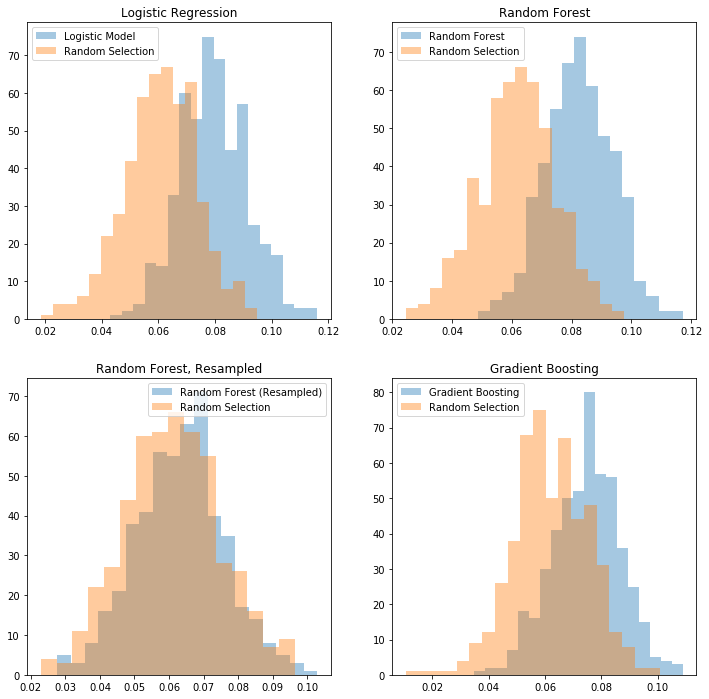

In [69]:
plt.figure(figsize=(12,12))

plt.subplot(2,2,1)
bal = [.5, .3, .2]
plt.title('Logistic Regression')
sns.distplot(simulation(portfolio_lg2, bal, n=500, s=500), label='Logistic Model', kde=False)
sns.distplot(simulation(loans_CDE, bal, n=500, s=500), label='Random Selection', kde=False)
plt.legend()

plt.subplot(2,2,2)
plt.title('Random Forest')
sns.distplot(simulation(portfolio_rf2, bal, n=500, s=500), label='Random Forest', kde=False)
sns.distplot(simulation(loans_CDE, bal, n=500, s=500), label='Random Selection', kde=False)
plt.legend()

plt.subplot(2,2,3)
plt.title('Random Forest, Resampled')
sns.distplot(simulation(portfolio_rf3, bal, n=500, s=500), label='Random Forest (Resampled)', kde=False)
sns.distplot(simulation(loans_CDE, bal, n=500, s=500), label='Random Selection', kde=False)
plt.legend()

plt.subplot(2,2,4)
plt.title('Gradient Boosting')
sns.distplot(simulation(portfolio_gb2, bal, n=500, s=500), label='Gradient Boosting', kde=False)
sns.distplot(simulation(loans_CDE, bal, n=500, s=500), label='Random Selection', kde=False)
plt.legend()


plt.savefig('returns_comparison.png')
plt.show()

In [71]:
returns = [np.mean(simulation(loans_CDE, bal, n=5000, s=500)),
    np.mean(simulation(portfolio_lg2, bal, n=5000, s=500)),
    np.mean(simulation(portfolio_rf2, bal, n=5000, s=500)),
    np.mean(simulation(portfolio_rf3, bal, n=5000, s=500)),
    np.mean(simulation(portfolio_gb2, bal, n=5000, s=500))]

In [72]:
from sklearn.metrics import average_precision_score, recall_score, accuracy_score

model_list = ['pred_lg2', 'pred_rf2', 'pred_rf3', 'pred_gb2']
model_list_bool = [x + '_bool' for x in model_list]
results = pd.DataFrame(columns = ['Model', 'ROC_AUC', 'Precision', 'Recall', 'Accuracy', 'Returns (WF)'])
results.Model = ['Logistic Regression', 'Random Forest', 'R.F. (balanced)', 'Gradient Boosting']
results.ROC_AUC = [roc_auc_score(wf['target'], wf[mod]) for mod in model_list]
results.Precision = [average_precision_score(wf.target, wf[x]) for x in model_list_bool]
results.Recall = [recall_score(wf.target, wf[x]) for x in model_list_bool]
results.Accuracy = [accuracy_score(wf.target, wf[x]) for x in model_list_bool]

results['Returns (WF)'] = returns[1:]

results

,Model,ROC_AUC,Precision,Recall,Accuracy,Returns (WF)
0,Logistic Regression,0.675146,0.848801,0.999902,0.848738,0.079025
1,Random Forest,0.675988,0.848771,1.000000,0.848771,0.081443
2,R.F. (balanced),0.660902,0.856407,0.963623,0.832310,0.063110
3,Gradient Boosting,0.665250,0.848801,0.999961,0.848779,0.073621


Finally, we compared our 4 selected models using more traditional classifier evaluation measures, as well as simulated walk-forward returns. Classifier models will predict an observation as "true," when the forecasted probability is greater than 50%. As a result, almost every data point is classified as true across every model, and precision, recall, and accuracy have limited relevance. The area under the ROC-AUC curve is better good way to evaluate probabilistic predictions in this context. However, the metric we really care about is investment returns from a portfolio directed by our model. 

Luckily, we do not have to decide between following the ROC-AUC score and the highest-returning model, because the same model, the random forest, performed best under both metrics. Our logistic regression model was a close second in both cases.

Overall, this project impressed on me how powerful random forests can be in a classification problem. I was especially surprised how accurate the predicted probabilities were. Additionally, it was shown that above-market returns can reliably be achieved with machine learning techniques in the Lending Club marketplace. 